In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Using TensorFlow backend.


Set random seed for reproducibility.

In [2]:
! cat '../input/m1-effnetb5-using-ram-fork1/history.json'

{"val_loss": [0.1563529010862112, 0.12603388916701078, 0.11127396337349306, 0.10333436048462648, 0.10711878703843633, 0.1069790358323371, 0.10509262462548742, 0.0990625977976544, 0.09791722674060359, 0.09826880635138051, 0.098140073670921, 0.09766121265233696, 0.09977302383007058, 0.10041783511109481, 0.10117310571756785, 0.10026571328516266, 0.09933460647453268, 0.10047129909729516, 0.10072035594226857, 0.10036781961783577], "val_acc": [0.9447272673520175, 0.9570909036289562, 0.9599999943646518, 0.9629090851003473, 0.9643636304681952, 0.962545448216525, 0.9603636299480092, 0.9643636309016834, 0.9654545402526855, 0.9643636317686601, 0.9639999948848378, 0.9647272673520175, 0.9629090851003473, 0.9607272668318315, 0.9647272673520175, 0.9654545406861739, 0.9650909046693281, 0.9643636313351718, 0.9647272677855058, 0.9650909042358399], "loss": [0.3080692183523221, 0.2134722927944366, 0.19419531482044405, 0.1703677022647697, 0.14884536119853087, 0.13207947300114983, 0.12437392957987393, 0.112

In [3]:
np.random.seed(2020)
tf.set_random_seed(2020)

# Loading & Exploration

In [4]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

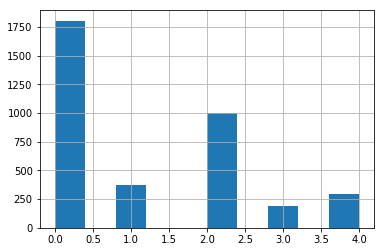

In [5]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

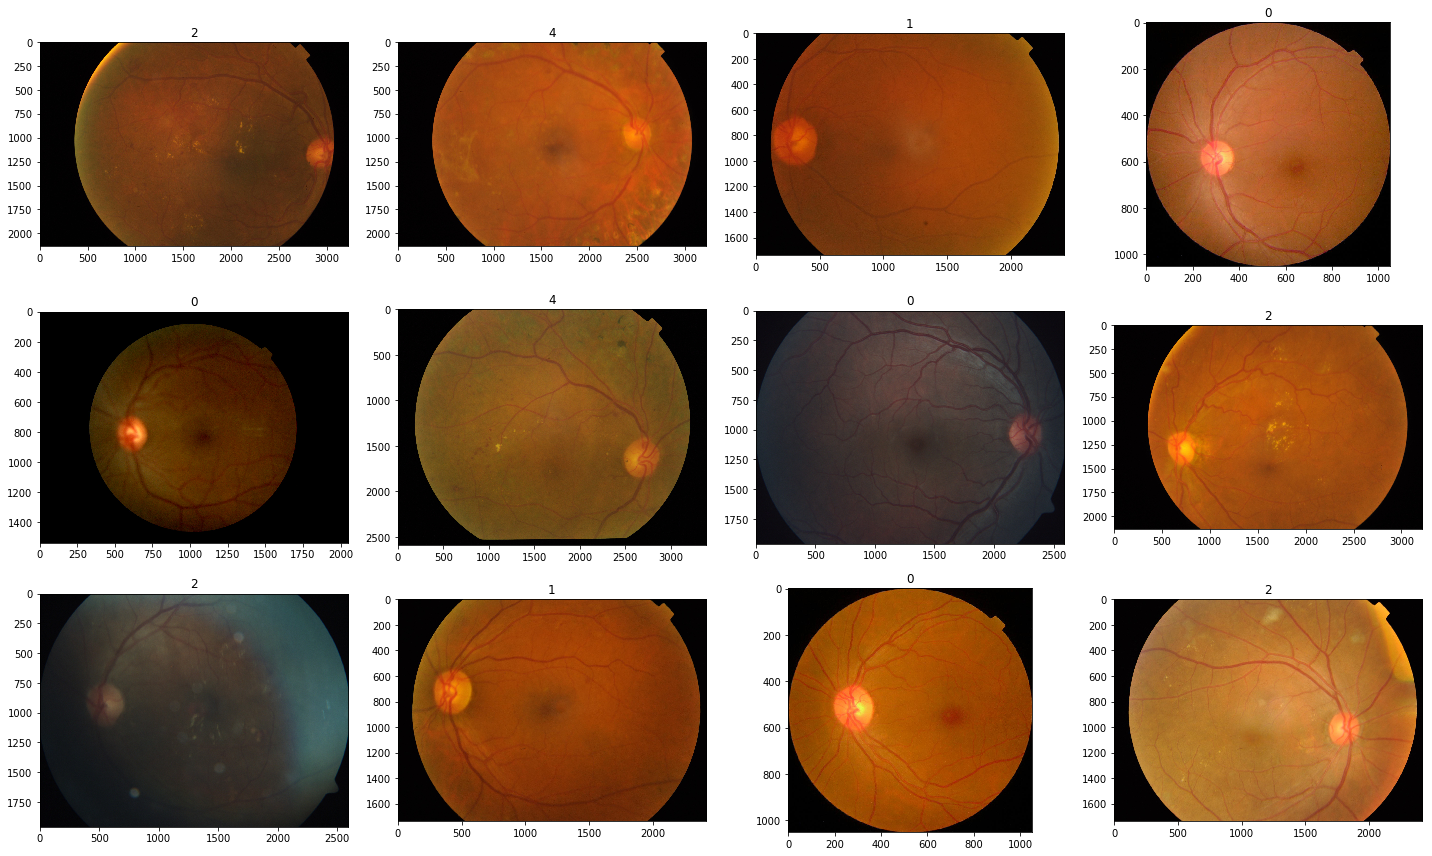

In [6]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Preprocess



In [7]:
# image height and image width ----> GLOBAL
img_ht = 400
img_wd = 400

def displayImage(display_name, image):
    cv2.namedWindow(display_name,cv2.WINDOW_AUTOSIZE)
    cv2.imshow(display_name, image)

def findContourEye(thresh_image):
    cnts = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
    cnts = max(cnts[0], key=cv2.contourArea)
    return cnts

def findContourEyeExtreme(cnts):
    # Locating extreme points on all 4 sides
    leftmost = tuple(cnts[cnts[:,:,0].argmin()][0])
    rightmost = tuple(cnts[cnts[:,:,0].argmax()][0])
    topmost = tuple(cnts[cnts[:,:,1].argmin()][0])
    bottommost = tuple(cnts[cnts[:,:,1].argmax()][0])
    # Locating the top left and bottom right corner
    x1 = leftmost[0]
    y1 = topmost[1]
    x2 = rightmost[0]
    y2 = bottommost[1]
    return x1,y1,x2,y2 

def findRadiusAndCentreOfContourEye(cnts):
    M = cv2.moments(cnts)
    if( M["m00"]==0):
        cX, cY = 0, 0
    else:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    if(cX < cY):
        r = cX
    else:
        r = cY
    return cX,cY,r

def drawCentreOnContourEye(image,cnts,cX,cY):
    cv2.drawContours(image, [cnts], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return image
    
def Radius_Reduction(img,cX,cY,r):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(cX),int(cY)),int(r), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

def imageResize(image, ht, wd):
    # resized_image = imutils.resize(image, height = ht, width = wd)
    resized_image = cv2.resize(image,(wd,ht))
    return resized_image

def crop_black(image):
    org = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
    # displayImage('thresh',thresh)
    cnts = findContourEye(thresh)
    x1,y1,x2,y2 = findContourEyeExtreme(cnts)
#     print(x1,y1,x2,y2)
    crop = org[y1:y2, x1:x2]
    crop = imageResize(crop, img_ht, img_wd)
    # displayImage("cr1",crop)
    return crop
#     ext_x = int((x2 - x1)*4//100)
#     ext_y = int((y2 - y1)*5//100)
#     print(ext_x,ext_y)
#     crop = org[y1+ext_y:y2-ext_y, x1+ext_x:x2-ext_x]
#     crop = imageResize(crop, img_ht, img_wd)
#     return crop

def imageAugmentation(image):
    x_flip = cv2.flip( image, 0 )
    y_flip = cv2.flip( image, 1 )
    xy_flip = cv2.flip(x_flip,1)
    return x_flip, y_flip, xy_flip

def imageHistEqualization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    sub_med = cv2.addWeighted (im, 1, bg, -1, 255)
    return sub_med

def colorEnhancement(image1,image2):
    image_final = cv2.bitwise_and(image1,image2)
    return image_final

def imageAugSave(path,img1,img2,img3,img4,img_ht,img_wd):
    count = len(os.listdir(path))

    img1 = imageResize(img1, img_ht, img_wd)
    img2 = imageResize(img2, img_ht, img_wd)
    img3 = imageResize(img3, img_ht, img_wd)
    img4 = imageResize(img4, img_ht, img_wd)

    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img1)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+2)), img2)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+3)), img3)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+4)), img4)
    return count+1,count+2,count+3,count+4

def processed_test_save(path,img,img_ht,img_wd):
    count = len(os.listdir(path))
    img = imageResize(img,img_ht,img_wd)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img)
    return count+1
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=400):
    image = cv2.imread(image_path)
    image = imageResize(image, desired_size, desired_size)
    image_crop = crop_black(image)
    image_clahe = imageHistEqualization(image_crop)
    sub_med = subtract_median_bg_image(image_clahe)
    image_final = colorEnhancement(sub_med, image_clahe)
    return image_final

# def preprocess_image(image_path, desired_size=380):
#     im = Image.open(image_path)
#     im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
#     return im

In [8]:
# def get_pad_width(im, new_shape, is_rgb=True):
#     pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
#     t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
#     l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
#     if is_rgb:
#         pad_width = ((t,b), (l,r), (0, 0))
#     else:
#         pad_width = ((t,b), (l,r))
#     return pad_width

# def preprocess_image(image_path, desired_size=456):
#     im = Image.open(image_path)
#     im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
#     return im

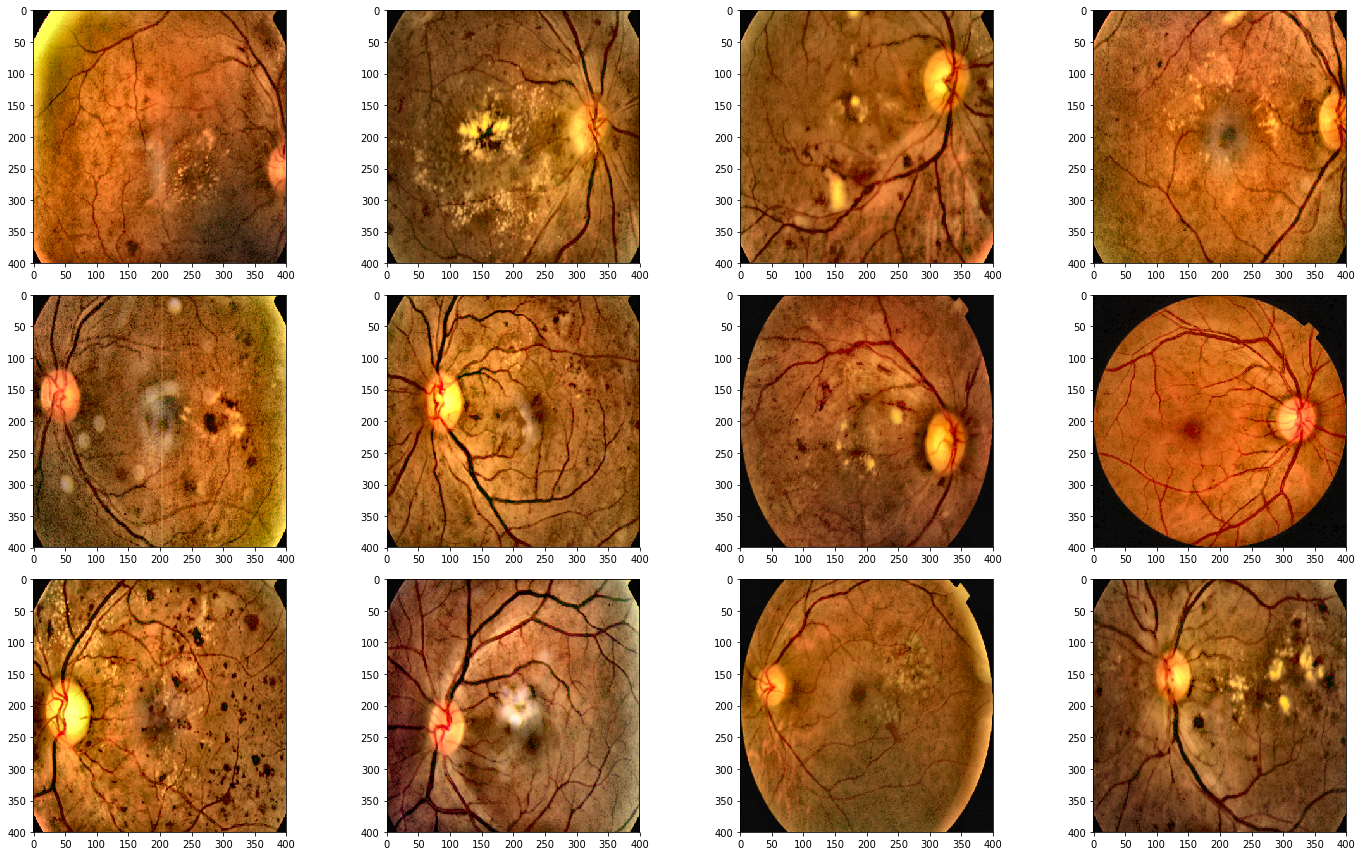

In [9]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
#         image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
#         plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(test_df)


# Efficienetnet

In [10]:
import gc
gc.collect()
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))

In [11]:
def build_model():
    model = Sequential()
    model.add(cnn_net)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [12]:
from efficientnet import EfficientNetB5
# Load in EfficientNetB5
cnn_net = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(400, 400, 3))
cnn_net.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

model = build_model()
model.load_weights('../input/m1-effnetb5-using-ram-fork1/model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 13, 13, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


## Submit

In [13]:
cnt = 0
for i in tqdm(range(0,300)):
    img = preprocess_image('../input/aptos2019-blindness-detection/train_images/%s.png'%train_df['id_code'][i])
    img = np.expand_dims(img,axis = 0)
    ans = model.predict(img) > 0.5
    ans = (ans.astype(int).sum(axis=1) - 1)[0]
    if(ans == train_df['diagnosis'][i]):
        cnt += 1
#     print(i,ans,train_df['diagnosis'][i])
print(cnt)
print(cnt/300)
import gc
gc.collect()


260
0.8666666666666667


0

In [14]:
test_df['diagnosis'] = 'NaN'
print(test_df.head())
for i in tqdm(range(0,len(test_df))):
    img = preprocess_image('../input/aptos2019-blindness-detection/test_images/%s.png'%test_df['id_code'][i])
    img = np.expand_dims(img,axis = 0)
    ans = model.predict(img) > 0.5
    ans = (ans.astype(int).sum(axis=1) - 1)[0]
    test_df['diagnosis'][i] = int(ans)

        id_code diagnosis
0  0005cfc8afb6       NaN
1  003f0afdcd15       NaN
2  006efc72b638       NaN
3  00836aaacf06       NaN
4  009245722fa4       NaN


In [15]:
test_df.to_csv('submission.csv',index = False)

In [16]:
test_df

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,2
8,01499815e469,3
9,0167076e7089,0
